In [1]:
import pandas as pd

path2csv = "/mnt/Extension/Codes/PyTorch_Computer_Vision_Cookbook/Cap2/data/train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# Exploring the dataset

In [2]:
# print the number of normal and malignant cases
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:>

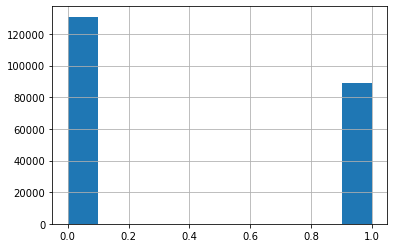

In [3]:
%matplotlib inline
labels_df['label'].hist()

In [4]:
# Visualize images with positive label
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [6]:
# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

In [11]:
# data is stored here
path2train = "/mnt/Extension/Codes/PyTorch_Computer_Vision_Cookbook/Cap2/data/train/"

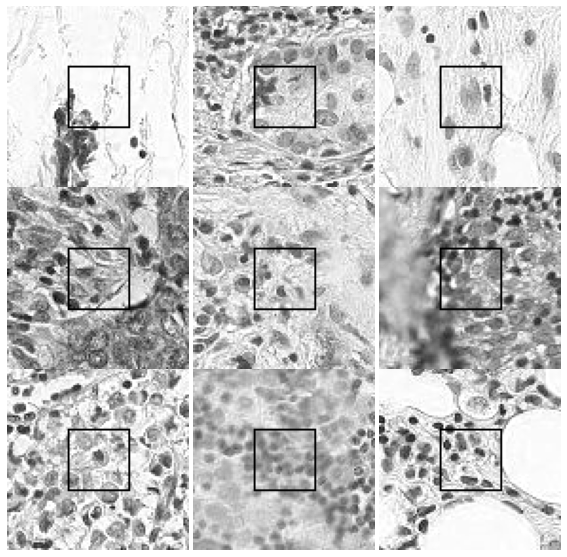

In [12]:
color=False

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3,3

for i, id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_ + '.tif')
    
    # load image
    img = Image.open(full_filenames)
    
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32), (64, 64)), outline="green")
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0], cmap="gray")
    plt.axis('off')

In [13]:
# Get image shape, minimum and maximum pixel values

print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))



image shape: (96, 96, 3)
pixel values range from 0 to 255


# Creating a custom dataset

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When creating a custom Dataset class, make sure to define two essential functions: $__len__$ and $__getitem__$. The $__len__$ function returns the dataset's length. This function is callable with the Python len function. The $__getitem__$ function returns an image at the specified
index.


In [14]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

In [23]:
# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):
        # path to images
        path2data=os.path.join(data_dir,data_type)
        # get a list of images
        filenames = os.listdir(path2data)
        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in
        filenames]

        # labels 
        csv_filename = data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir, csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [24]:
# convert PIL image into pytorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [25]:
data_dir = "/mnt/Extension/Codes/PyTorch_Computer_Vision_Cookbook/Cap2/data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [26]:
# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


# Splitting the dataset



### We need to provide a validation dataset to track the model's performance during training. We use 20% of histo_dataset as the validation dataset and use the rest as the training dataset.

In [28]:
# split histo_dataset
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [30]:
# get image from validation dataset

for x,y in val_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 0


In [31]:
# display samples from train_ds
from torchvision import utils
np.random.seed(0)

In [33]:
# define a helper function to show an image
def show(img, y, color=False):
    # convert tensor to numpe array
    npimg = img.numpy()
    # convert to H*W*C shape
    npimg_tr = np.transpose(npimg, (1,2,0))
    if color==False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest',cmap='gray')
    else:
        # display images
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title("label: "+str(y))

image indices: [ 95939  97639  41993 122579]
torch.Size([3, 100, 394])


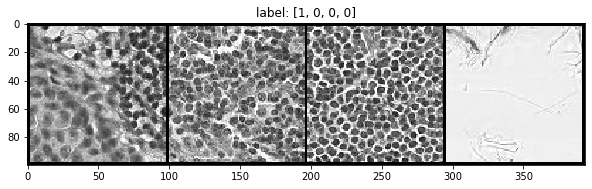

In [35]:
# create a grid of sample images:
grid_size=4
rnd_inds=np.random.randint(0, len(train_ds), grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize']=(10.0,5)
show(x_grid_train, y_grid_train)

image indices: [20757 14935 15430 39512]
torch.Size([3, 100, 394])


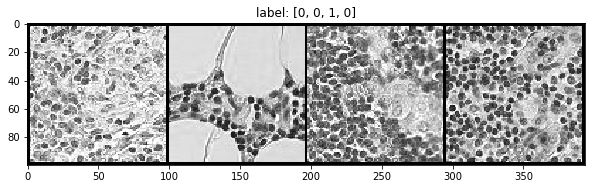

In [37]:
# We can also show a few samples from val_ds
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]
x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
show(x_grid_val,y_grid_val)

